# fMRI 2nd Level (GROUP) Analysis

Perform group analysis on SPM normalized data-adapted from https://miykael.github.io/nipype_tutorial/notebooks/example_2ndlevel.html 

The contrast calculated individually are fed into a GLM that implements a statistical test (in the example a simple T-test to assess if group mean activation is significant)

## import

In [1]:
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip
from bids.layout import BIDSLayout


import nibabel as nb
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat

from nilearn.plotting import plot_stat_map, plot_glass_brain, plot_anat
tpm_img ='/home/ubuntu/Documents/MATLAB/spm12/tpm/TPM.nii'  #template normalize SPM

191111-17:57:55,141 nipype.utils INFO:
	 Running nipype version 1.2.3 (latest: 1.2.3)


/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## experiment parameters

In [2]:
data_dir='/home/ubuntu/Documents/BIDs/XP2'
experiment_dir='/home/ubuntu/Documents/windowshare/output/XP2'
output_dir='datasink'
working_dir='workingdir'

subject_list_2d=['xp204','xp205','xp207','xp210','xp212','xp213','xp215','xp216','xp217','xp221','xp223']
subject_list=['xp201','xp202','xp203','xp206','xp208','xp209','xp211','xp214','xp218','xp219','xp220','xp222','xp204','xp205','xp207','xp210','xp212','xp213','xp215','xp216','xp217','xp221','xp223']


task_list=['NF']
run_list=['01','02','03']
fwhm=[6]
# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002']


## Specify Nodes for Workflow

In [ ]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")


  ## Input and Output

In [ ]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id','task_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list),
                        ('task_id',task_list)]
                       

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons': opj(output_dir, 'normalized', 'sub-*',
                         'run-*-w{contrast_id}.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', ''),
                ('_task_id_','/task-')]

datasink.inputs.substitutions = substitutions


## Connect workflow nodes

In [ ]:
# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('task_id','task_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

## apply grey matter mask 
Use a gray matter mask to restrict the analysis to only gray matter voxels.

Contrast were normalized to SPM12 TPM.nii tissue probability atlas. We take the gray matter probability map of this TPM.nii image (the first volume) and threshold it at a certain probability value to get a binary mask (bash). This can be run only once at the beginning of the analysis.

In [ ]:
# TO RUN ONLY ONCE TO EXTRACT GRAY MATTER MASK

%%bash
TEMPLATE='/home/ubuntu/Documents/MATLAB/spm12/tpm/TPM.nii'

# Extract the first volume with `fslroi`
fslroi $TEMPLATE GM_PM.nii.gz 0 1

# Threshold the probability mask at 10%
fslmaths GM_PM.nii -thr 0.10 -bin /home/ubuntu/Documents/windowshare/output/XP2/datasink/GM_mask.nii.gz

# Unzip the mask and delete the GM_PM.nii file
gunzip /home/ubuntu/Documents/windowshare/output/XP2/datasink/GM_mask.nii.gz
rm GM_PM.nii.gz



In [ ]:
mask = nb.load('/home/ubuntu/Documents/windowshare/output/XP2/datasink/GM_mask.nii')
mask.orthoview()

In [ ]:
# aplly GM mask to contrast files
onesamplettestdes.inputs.explicit_mask_file ='/home/ubuntu/Documents/windowshare/output/XP2/datasink/GM_mask.nii'

## visualize workflow

In [ ]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'spm_l2analysis', 'graph.png'))

## RUN

In [ ]:
l2analysis.run()

In [ ]:
from nipype.interfaces.image import Reorient
reorient=Reorient(orientation='RAS')
reorient.inputs.in_file='/home/ubuntu/Documents/windowshare/output/XP2/datasink/2ndlevel/con_0001/task-2dNF/spmT_0001.nii'
reorient.out_file='/home/ubuntu/Documents/windowshare/output/XP2/datasink/2ndlevel/con_0001/task-2dNF/spmT_0001_ras.nii'
res=reorient.run()
print(np.loadtxt(res.outputs.transform))

In [ ]:
from nipype.interfaces.image import Reorient
reorient=Reorient(orientation='RAS')
reorient.inputs.in_file='/home/ubuntu/Documents/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c.nii'
reorient.out_file='/home/ubuntu/Documents/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_ras.nii'
res=reorient.run()

print(np.loadtxt(res.outputs.transform))
res.outputs.out_file

##  Examples of results VISUALIZATION 

In [ ]:
anatimg = '/home/ubuntu/Documents/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c.nii'

plot_stat_map( '/home/ubuntu/Documents/windowshare/output/XP2/datasink/2ndlevel/con_0001/task-NF/con_0001.nii', title='con 1 fwhm=6', dim=1,
    bg_img=anatimg, threshold=0.6, vmax=3,display_mode='ortho', cut_coords=(-23,-8,56),cmap='viridis');

In [ ]:
anatimg = '/home/ubuntu/Documents/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c.nii'

plot_stat_map(
    '/home/ubuntu/Documents/windowshare/output/XP2/datasink/2ndlevel/con_0002/task-2dNF/con_0001.nii', title='con 2 fwhm=6', dim=1,
    bg_img=anatimg, threshold=1,display_mode='z', cut_coords=(30,40,50,55,60), cmap='viridis',symmetric_cbar=0);

In [ ]:
anatimg = '/home/ubuntu/Documents/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c.nii'

plot_stat_map(
    '/home/ubuntu/Documents/windowshare/output/XP2/datasink/2ndlevel/con_0002/task-1dNF/con_0001.nii', title='con 2 fwhm=6', dim=1,
    bg_img=anatimg, threshold=1,display_mode='z', cut_coords=(30,40,50,55,60), cmap='viridis',symmetric_cbar=0);

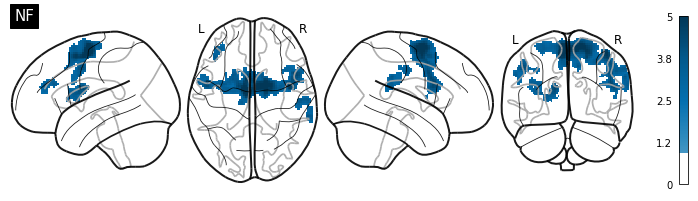

In [79]:

plot_glass_brain('/home/ubuntu/Documents/windowshare/output/XP2/datasink/2ndlevel/con_0001/task-NF/spmT_0001_thr.nii',
                 colorbar=True, display_mode='lzry', vmax=5, black_bg=False, plot_abs=False,title='NF',alpha=0.9, threshold=1,cmap='PuBu');


fname='/home/ubuntu/Documents/windowshare/output/XP2/datasink/2ndlevel/con_0001/task-NF/spmT_0001_glassbrain_thr_deactivation_PuBu'
plt.savefig(fname,quality=100,dpi=100)

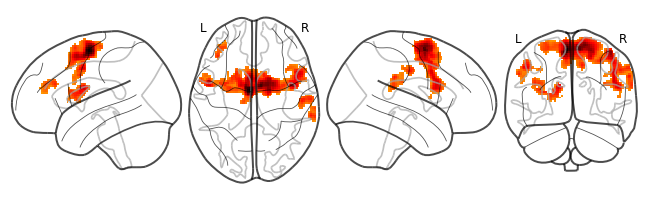

In [62]:

stat_img='/home/ubuntu/Documents/windowshare/output/XP2/datasink/2ndlevel/con_0001/task-NF/spmT_0001_thr.nii'

display=plotting.plot_glass_brain(stat_img, display_mode='lzry', black_bg=False, plot_abs=False)

#display.add_contours=(stat_img)


In [29]:
#threshold contrast to show only activation
from nipype.interfaces.fsl.maths import Threshold

ThresH=Threshold()
ThresH.inputs.in_file='/home/ubuntu/Documents/windowshare/output/XP2/datasink/2ndlevel/con_0001/task-NF/con_0001.nii'
ThresH.inputs.thresh=-10.0
ThresH.input_spec.thresh=-10.0
ThresH.inputs.direction='below'
ThresH.inputs.out_file='/home/ubuntu/Documents/windowshare/output/XP2/datasink/2ndlevel/con_0001/task-NF/con_0001_thr.nii'

res=ThresH.run()
print(res.outputs)




out_file = /home/ubuntu/Documents/windowshare/output/XP2/datasink/2ndlevel/con_0001/task-NF/con_0001_thr.nii



In [ ]:
plot_glass_brain('/home/ubuntu/Documents/windowshare/output/XP2/datasink/2ndlevel/con_0002/task-2dNF/con_0001.nii',
                 colorbar=True, display_mode='ortho', black_bg=False, threshold=2.5,cut_coords=(0,0,60),
                 title='2dNF');